Visco-elasto-plasticity in simple shear
======

In [1]:
import UWGeodynamics as GEO

loaded rc file /Users/rfarrington/Underworld/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

# Analysis

In [3]:
eta     = 1e22 * u.pascal * u.second # Viscosity
mu      = 10 * u.gigapascal # Shear Modulus
density = 2700 * u.kilogram / u.metre**3
gravity = 9.81 * u.metre / u.second**2
alpha = eta / mu # Relaxation time

# Scaling

In [4]:
model_height = 100. * u.kilometer
bodyforce = density * gravity

KL = model_height 
Kt = alpha
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
Model = GEO.Model(elementRes=(16, 16),
                  minCoord=(0., 0.),
                  maxCoord=(100. * u.kilometer, 100. * u.kilometer),
                  periodic=[True, False])

In [6]:
Model.outputDir="ViscoElastoPlasticShear"

## Materials

In [7]:
viscoelastic = Model.add_material(name="Visco Elastic", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
viscoelasticBar = Model.add_material(name="Visco Elastic Bar", shape=GEO.shapes.Box(minX=40. * u.kilometer,
                                                                                    maxX=60. * u.kilometer,
                                                                                    top=Model.top,
                                                                                    bottom=Model.bottom))


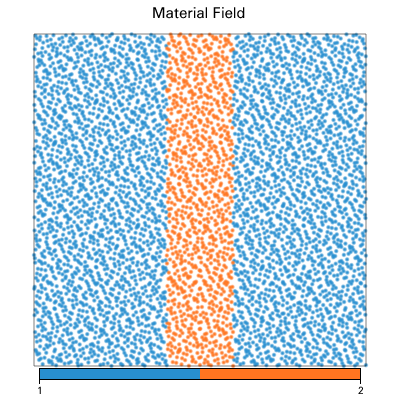

In [8]:
Fig = Model.plot.material(figsize=(400,400), fn_size=5.)

### Densities

In [9]:
viscoelastic.density = 2700. * u.kilogram / u.metre**3
viscoelasticBar.density = 2700. * u.kilogram / u.metre**3

### Viscosities

In [10]:
viscoelastic.viscosity = 1e22 * u.pascal * u.second
viscoelasticBar.viscosity = 1e22 * u.pascal * u.second

### Plasticity

In [11]:
# viscoelastic.plasticity = GEO.VonMises(cohesion=10. * u.megapascal)
# viscoelasticBar.plasticity = GEO.VonMises(cohesion=10. * u.megapascal)

### Elasticity

In [12]:
viscoelastic.elasticity = GEO.Elasticity(shear_modulus=10. * u.gigapascal,
                                         observation_time=20000. * u.year)
viscoelasticBar.elasticity = GEO.Elasticity(shear_modulus=10. * u.gigapascal,
                                         observation_time=20000. * u.year)

## Velocity Boundary conditions

In [13]:
Model.set_velocityBCs(top=[0.5 * u.centimeter / u.year, 0], bottom=[0, 0])

## Tracers

In [14]:
tracerSolo = Model.add_passive_tracers(name="Single Tracer", 
                                       vertices=[50. * u.kilometer,
                                                 50. * u.kilometer])


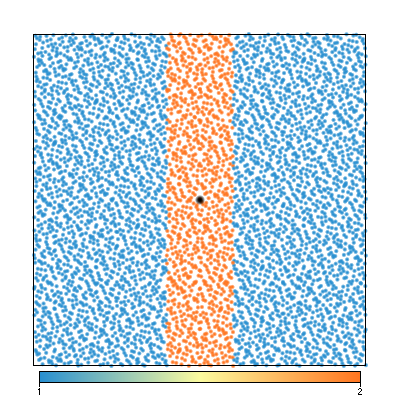

In [15]:
import glucifer

figMaterial = glucifer.Figure(figsize=(400,400))
figMaterial.Points(tracerSolo.swarm, pointSize=10, colourBar=False)
figMaterial.Points(Model.swarm, Model.materialField, pointSize=5)
figMaterial.show()

In [16]:
GEO.rcParams["solver"] = "lu"

In [17]:
tTracer      = [GEO.nd(Model.time)]
previousStress_xy  = [0.]

def postSolveHook():
    global tTracer, previousStress_xy
    tTracer.append(GEO.nd(Model.time))
    previousStress_xy.append(
        Model._previousStressField[2].evaluate(Model.swarm)[0])

In [18]:
Model.postSolveHook = postSolveHook

In [19]:
Model.run_for(200000. * u.years)

Time:  6666.66666667 year dt: 6666.66666667 year
Time:  13333.3333333 year dt: 6666.66666667 year
Time:  20000.0 year dt: 6666.66666667 year
Time:  26666.6666667 year dt: 6666.66666667 year
Time:  33333.3333333 year dt: 6666.66666667 year
Time:  40000.0 year dt: 6666.66666667 year
Time:  46666.6666667 year dt: 6666.66666667 year
Time:  53333.3333333 year dt: 6666.66666667 year
Time:  60000.0 year dt: 6666.66666667 year
Time:  66666.6666667 year dt: 6666.66666667 year
Time:  73333.3333333 year dt: 6666.66666667 year
Time:  80000.0 year dt: 6666.66666667 year
Time:  86666.6666667 year dt: 6666.66666667 year
Time:  93333.3333333 year dt: 6666.66666667 year
Time:  100000.0 year dt: 6666.66666667 year
Time:  106666.666667 year dt: 6666.66666667 year
Time:  113333.333333 year dt: 6666.66666667 year
Time:  120000.0 year dt: 6666.66666667 year
Time:  126666.666667 year dt: 6666.66666667 year
Time:  133333.333333 year dt: 6666.66666667 year
Time:  140000.0 year dt: 6666.66666667 year
Time:  146

1


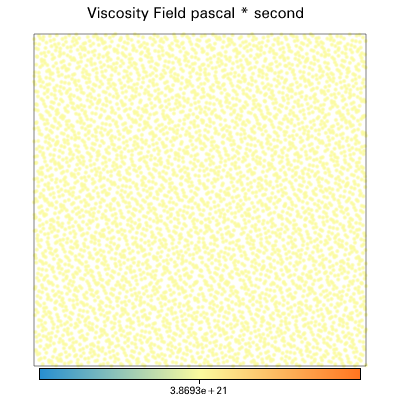

In [20]:
Fig = Model.plot.viscosity(figsize=(400,400), fn_size=5., logScale=True)


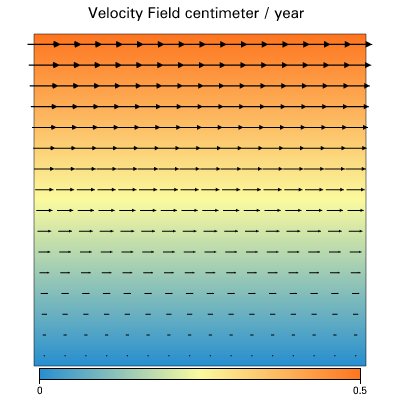

{'antialias': True,
 'axis': False,
 'background': 'white',
 'border': 1,
 'bordercolour': 'black',
 'boundingBox': ((0.0, 0.0), (1.0, 1.0)),
 'margin': 34,
 'max': (1.0, 1.0),
 'min': (0.0, 0.0),
 'quality': 3,
 'resolution': (400, 400),
 'rulers': False,
 'title': 'Velocity Field centimeter / year',
 'zoomstep': 0}

In [21]:
Model.plot.velocityField(figsize=(400,400))


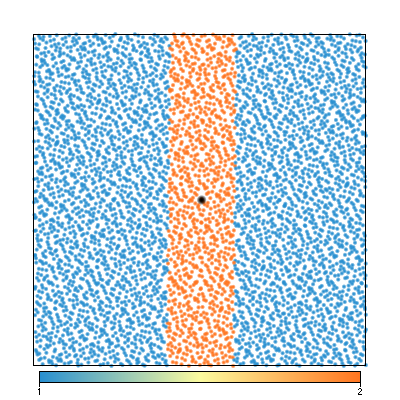

In [22]:
figMaterial.show()

In [23]:
# tTracer

In [24]:
# totalStress_xy

In [25]:
import numpy as np

# analytic soln of elastic shear stress component
V  = 0.5 * u.centimetre / u.year
h  = 100. * u.kilometer
eta = 1e22 * u.pascal * u.second
mu = 10. * u.gigapascal
t_relax = 32000 * u.years
C1 = -V*V*eta*eta*mu/(mu*mu*h*h + V*V*eta*eta);
C2 = -V*h*eta*mu *mu/(mu*mu*h*h + V*V*eta*eta);

increment =  301 #int(10 / (dt_e / 3.0) )
t = np.linspace(0, 10*t_relax, increment)
t *= u.years

analyticSoln = np.exp(-mu/eta*t)*(C2*np.cos(V*t/h)-C1*np.sin(V*t/h))-C2

In [26]:
import pylab as plt

plt.plot(t, analyticSoln.to(u.pascal))
plt.xlim(0, 200000)
plt.show()

In [27]:
# analyticSoln[10].to(u.pascal)

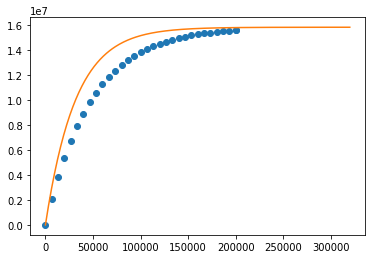

In [28]:
import pylab as plt

plt.plot(GEO.Dimensionalize(tTracer, u.years), GEO.Dimensionalize(previousStress_xy, u.pascal), "o")
plt.plot(t.to(u.years), analyticSoln.to(u.pascal))
plt.show()

In [29]:
# GEO.nd(10. * u.megapascal)

In [30]:
# Model.plot.velocityField()

In [31]:
# Model.plot.strainRate()

In [32]:
# (8e-16 / u.second).to(1/u.years)

In [33]:
# Model.maxViscosity

In [34]:
# A = viscoelasticBar.elasticity._effectiveViscosity()

In [35]:
# GEO.Dimensionalize(A.evaluate(Model.swarm), u.pascal * u.second)